In [66]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
from tqdm import tqdm
from scipy.stats import norm 

# Create output directory
base_path='./outputPython0406_logOdds'
import os
if not os.path.exists(base_path):
    os.makedirs(base_path)

np.random.seed(1)

sigma = 2  # Noise standard deviation

In [67]:
# Load letter A image and binarize it to +1/-1 values
img = pd.read_csv('https://raw.githubusercontent.com/probml/probml-data/main/data/letterA.csv',header=None).to_numpy()
print(img.shape)
mean_img = np.mean(img)
print(mean_img)
img2 = np.where(img >= mean_img, 1, -1)
# Add Gaussian noise to create noisy image
y = img2 + sigma*np.random.normal(size = img2.shape)


(128, 128)
79.38787841796875


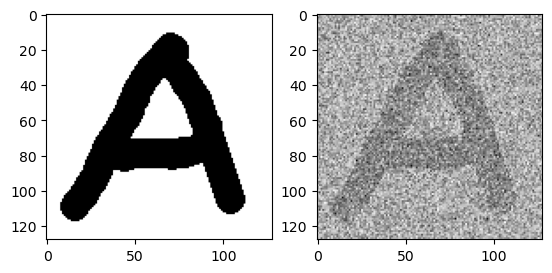

In [68]:
# Load pre-computed logOdds from external source
logOdds = pd.read_csv('https://github.com/aqlkzf/STAT6250-ProbabilisticMachineLearning-2025Spring/raw/refs/heads/main/Assignment2/beta_s.csv',header=None).to_numpy()

# Plot original and noisy images
fig, axs = plt.subplots(1,2)
axs[0].imshow(img2, cmap="Greys")
axs[1].imshow(y, cmap="Greys")
plt.savefig(os.path.join(base_path, 'denoising.pdf'))

## Sigmoid Function

The sigmoid function is defined as:

$$\sigma(u) = \frac{1}{1+e^{-u}}$$

This function maps any real-valued number to a value between 0 and 1, which can be interpreted as a probability.
In the context of the Ising model, it's used to compute the probability of a pixel taking the value +1.


In [69]:
# Sigmoid function for probability calculations
def sigmoid(x):
  return 1/(1+np.exp(-x))

## Neighbor Summation

This function calculates the total contribution of a pixel’s neighbors at position (ix, iy). It computes the neighbor sum using the formula:

$$\eta_s = \sum_{t \in \text{Nbr}(s)} \beta_{st} \cdot z_t$$

Where:
- $\text{Nbr}(s)$ represents the 4-connected neighbors (up, down, left, right) of pixel $s$
- $\beta_{st}$ is the interaction strength between pixels $s$ and $t$ (set to $J$ in this implementation)
- $z_t$ is the current state of neighbor pixel $t$

The function returns $2 \cdot J \cdot \sum_{t \in \text{Nbr}(s)} z_t$, which is used in both Gibbs sampling and mean field updates.


In [70]:
# Calculate local energy based on neighboring pixels
def NeighborSum(ix, iy, X, J):
  wi = 0
  if iy > 0:
    wi += X[iy-1, ix]  # Top neighbor
  if iy < X.shape[0]-1:
    wi += X[iy+1, ix]  # Bottom neighbor
  if ix > 0:
    wi += X[iy, ix-1]  # Left neighbor
  if ix<X.shape[1]-1:
    wi += X[iy, ix+1]  # Right neighbor
  return 2*J*wi 

## Gibbs Sampling Algorithm

Gibbs sampling is a Markov Chain Monte Carlo (MCMC) method used to sample from the posterior distribution in the Ising model.

### Algorithm:
1. **Initialization**:  
   Set each pixel $z_s$ by thresholding the noisy image:
   $$z_s^{(0)}=\begin{cases}
   +1 & \text{if } \text{img}_s \geq \text{mean(img)},\\
   -1 & \text{otherwise}.
   \end{cases}$$

2. **Iterative Updates**:
   - Randomly select a pixel $s \in V$
   - Compute the local field: $\eta_s = \sum_{t \in \text{Nbr}(s)} \beta_{st} \cdot z_t + \beta_s$
   - Compute the probability: $\theta_s = \sigma(2\eta_s)$, where $\sigma(u)=\frac{1}{1+e^{-u}}$
   - Sample the state of $s$ as:
     $$z_s=\begin{cases}
     +1 & \text{with probability }\theta_s,\\
     -1 & \text{with probability }1-\theta_s.
     \end{cases}$$

3. **Output**:
   - After burn-in, collect samples at regular intervals and average them to get the denoised image.

In this implementation:
- $\beta_{st} = J = 1$ for all neighboring pixels
- $\beta_s$ is provided by the logOdds values (precomputed)
- Burn-in period is set to 80% of the total iterations


In [71]:
# Gibbs sampling for image denoising
def gibbs(rng, img, J, niter=10,pre_computed_logOdds=None):
  if not niter:
    return img 
  # Binarize input image
  img2 = img.copy()
  mean = np.mean(img2)
  img2 = np.where(img2 >= mean, 1, -1)
  # Use pre-computed logOdds 
  if pre_computed_logOdds is None:
    print("No pre-computed logOdds provided")
  else:
    logOdds = pre_computed_logOdds

  for iter in tqdm(range(niter)):
    # Randomly select a pixel to update
    ix = rng.integers(0, img.shape[1])
    iy = rng.integers(0, img.shape[0])
    
    e = NeighborSum(ix, iy, img2, J)  # Calculate local energy
  
    # Update pixel value based on conditional probability
    if rng.random(1) < sigmoid(e + logOdds[iy, ix]):
      img2[iy, ix] = 1
    else:
      img2[iy, ix] = -1
    
    return img2

## Mean Field Variational Inference Algorithm

Mean field variational inference approximates the posterior distribution by a factorized distribution where each pixel is independent.

### Algorithm:
1. **Initialization**:  
   Set each pixel $\mu_s$ by thresholding the noisy image:
   $$\mu_s^{(0)}=\begin{cases}
   +1 & \text{if } \text{img}_s \geq \text{mean(img)},\\
   -1 & \text{otherwise}.
   \end{cases}$$

2. **Iterative Updates**:
   - Randomly select a pixel $s \in V$
   - Update the mean for pixel $s$ via:
     $$\mu_s^{(k)} \leftarrow \tanh\left(\sum_{t \in \text{Nbr}(s)} \beta_{st} \cdot \mu_t^{(k-1)} + \beta_s\right)$$
   where the hyperbolic tangent is defined as $\tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$

3. **Output**:
   - The final values of $\mu$ represent the expected values of the pixels in the denoised image.

In this implementation:
- $\beta_{st} = J = 1$ for all neighboring pixels
- $\beta_s$ is provided by the logOdds values (precomputed)
- A damping factor (rate) is applied to stabilize the updates


In [72]:
# Mean field approximation for image denoising
def meanfield(img, J, niter=10,  pre_computed_logOdds=None):
  # Use pre-computed logOdds 
  if pre_computed_logOdds is None:
    print("No pre-computed logOdds provided")
  else:
    logOdds = pre_computed_logOdds
  mean = np.mean(img)
  img2 = np.where(img > mean, 1.0, -1.0)
  # set dtype to float32
  img2 = img2.astype(np.float32)

  mu = img2  # Initialize mean field with binarized image
  
  if not niter:
    return img 

  # Iterative mean field updates
  for iter in tqdm(range(niter)): 
    # Randomly select a pixel to update
    ix = np.random.randint(0, img.shape[1])
    iy = np.random.randint(0, img.shape[0])
    
    Sbar = NeighborSum(ix, iy, mu, J)  # Calculate local field
    # Update mean field estimate 
    mu[iy, ix] = np.tanh(Sbar + logOdds[iy, ix])
    
  return mu

In [73]:
# Mean field approximation for image denoising
def meanfield(img, J, niter=10, pre_computed_logOdds=None):
  img2 = img.copy()


  logOdds = pre_computed_logOdds
  mean_img = np.mean(img)
  print(mean_img)
  base = np.ones(img.shape)
  # img2 = base*(img2 > mean_img) - base*(img2<=mean_img)
  img2 = np.where(img > mean_img, 1.0, -1.0)
  # set dtype to float32
  img2 = img2.astype(np.float32)
    
  mu = img2  # Initialize mean field with binarized image
  
  if not niter:
    return img 

  # Iterative mean field updates
  for iter in tqdm(range(niter)): 
    # Randomly select a pixel to update
    ix = np.random.randint(0, img.shape[1])
    iy = np.random.randint(0, img.shape[0])
    
    Sbar = NeighborSum(ix, iy, mu, J)  # Calculate local field
    # Update mean field estimate with damped update
    mu[iy, ix] = np.tanh(Sbar + 0.5*logOdds[iy, ix])
    
  return mu

In [74]:
# Setup for visualization
seed = 10
rng = np.random.default_rng(seed)
total_pixels = y.shape[0] * y.shape[1]

# Define iteration counts for visualization
iters=[82000, 163000, 245000, 330000, 500000, 600000]
print(iters)

[82000, 163000, 245000, 330000, 500000, 600000]


-0.4562775509574102


100%|██████████| 82000/82000 [00:00<00:00, 180954.09it/s]


-0.4562775509574102


100%|██████████| 163000/163000 [00:00<00:00, 207500.80it/s]


-0.4562775509574102


100%|██████████| 245000/245000 [00:01<00:00, 209006.37it/s]


-0.4562775509574102


100%|██████████| 330000/330000 [00:01<00:00, 208783.99it/s]


-0.4562775509574102


100%|██████████| 500000/500000 [00:02<00:00, 205922.16it/s]


-0.4562775509574102


100%|██████████| 600000/600000 [00:02<00:00, 203154.77it/s]


<Figure size 2400x500 with 0 Axes>

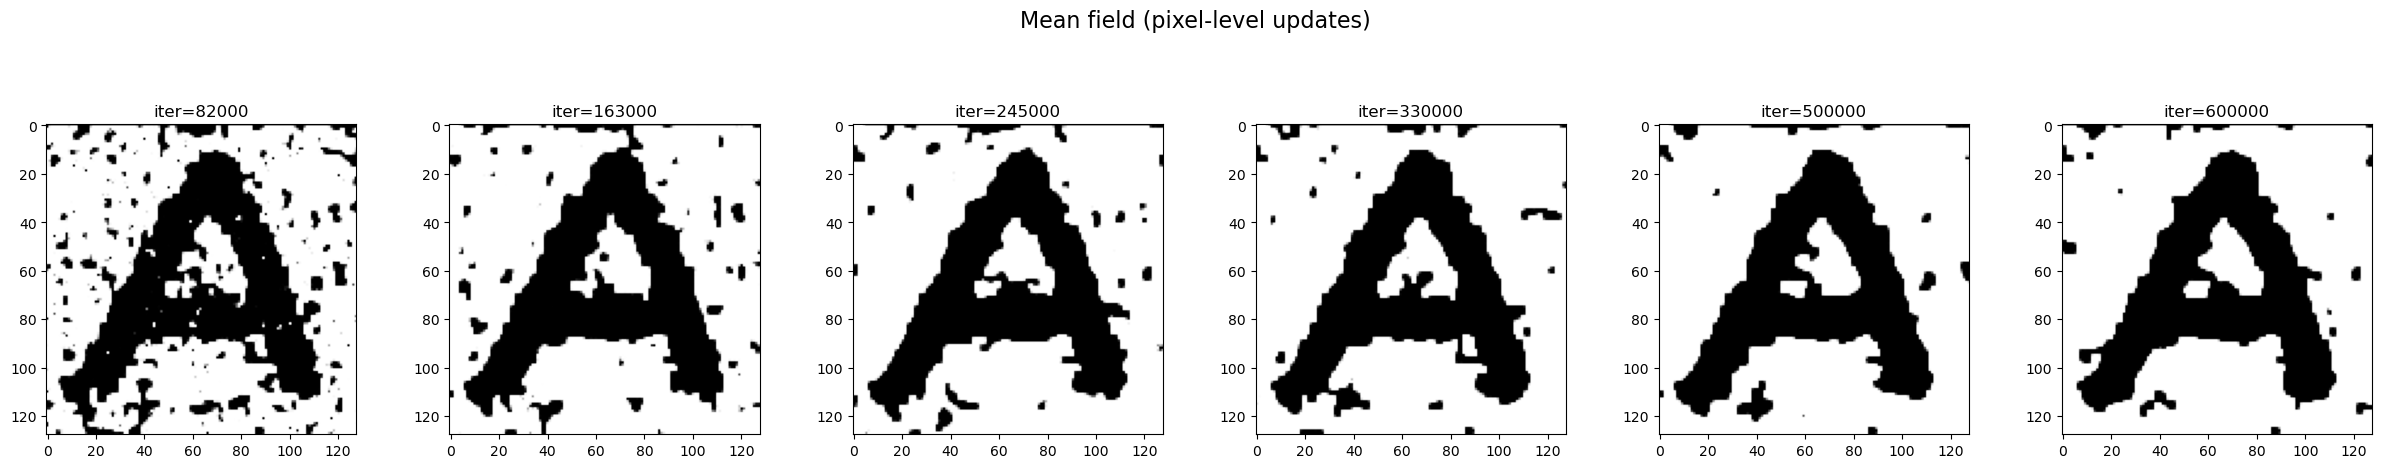

In [75]:
# Mean field visualization at different iteration counts
plt.figure(figsize=(4*len(iters), 5))
fig, axs = plt.subplots(1, len(iters), figsize=(4*len(iters), 5))
for i, x in enumerate(iters):
  axs[i].imshow(meanfield(y, 1, niter=x, pre_computed_logOdds=logOdds), cmap="Greys")
  axs[i].set_title(f"iter={x}", fontsize=12)

fig.suptitle('Mean field (pixel-level updates)', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.3)
plt.savefig(os.path.join(base_path, 'meanFieldDenoising.pdf'), bbox_inches='tight')


  0%|          | 0/600000 [00:00<?, ?it/s]


<Figure size 2400x500 with 0 Axes>

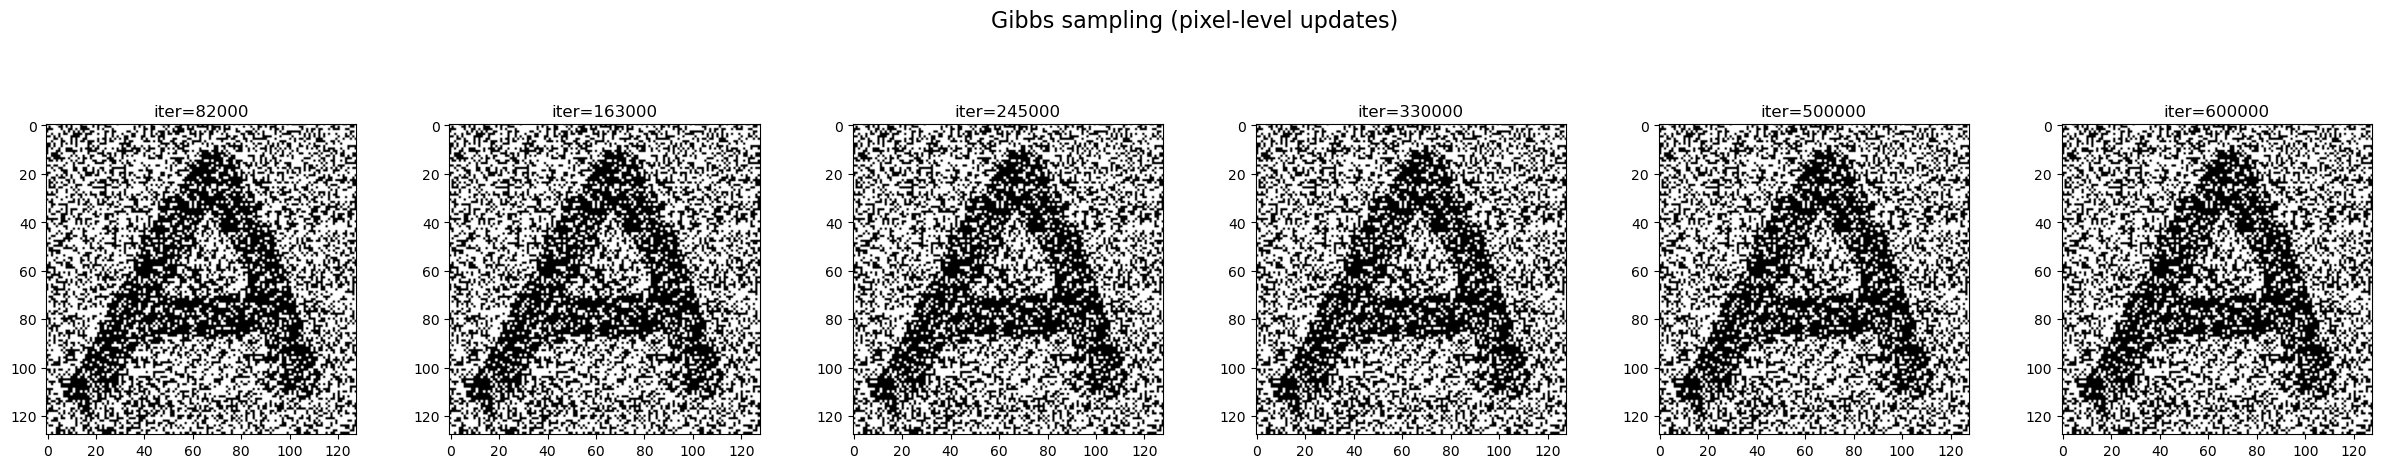

In [76]:
# Gibbs sampling visualization at different iteration counts
plt.figure(figsize=(4*len(iters), 5))
fig, axs = plt.subplots(1, len(iters), figsize=(4*len(iters), 5))
for i, x in enumerate(iters):
  axs[i].set_title(f"iter={x}", fontsize=12)
  axs[i].imshow(gibbs(rng, y, 1, niter=x, pre_computed_logOdds=logOdds), cmap="Greys")

fig.suptitle('Gibbs sampling (pixel-level updates)', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.3)
plt.savefig(os.path.join(base_path, 'gibbsDenoising.pdf'), bbox_inches='tight')
